# Final Project: Building energy comsumption analysis and prediction

## Content
1. [Motivation](#Motivation)
2. [Raw Data to Conclusion: Pipeline](#Pipeline)
3. [Data collection](#Data-collection)
4. [Data processing](#Data-processing)
  1. [Data loading and cleaning](#4.A-Data-loading-and-cleaning)
  2. [Feature engineering](#4.B-Feature-engineering)
  3. [Remove outliers](#4.C-Remove-outliers)
5. [Energy consumption prediction](#Energy-consumption-prediction)
  1. [Linear model: Ridge regression with/without PCA](#5.A-Linear-model:-Ridge-regression-with/without-PCA)
  2. [Non-linear model: Random forest regressor and LightGBM](#5.B-Non-linear-model:-Random-forest-regressor-and-LightGBM)
  3. [Model comparison & Effect of outliers to linear model performance](#5.C-Model-comparison-&-Effect-of-outliers-to-linear-model-performance)

6. [Feature importance](#Feature-importance)
7. [Conclusion](#Conclusion)
8. [Resources and future study](#Resources-and-future-study)

## Motivation


Energy has both economic and environmental meanings. Among major sectors, building energy usage takes 20% to 40% of the total energy consumption and 30% of total CO2 emissions in developed countries. Also, the Heating, Ventilation, and Air-Conditioning (HVAC) systems takes **50% of the whole building energy consumption** (Pérez-Lombard, L. et al., 2008). Therefore, the HVAC systems would be the most critical characteristics for building energy usage.

Accurate peak load prediction will help improve the efficiency of plant operation and save resources. Building energy usage prediction is complicated, influenced by many factors, such as outdoor climate, building envelope material property, HVAC systems performance, indoor environment, occupant schedule, etc. (Zhao, H. X., & Magoulès, F. 2012). **The motivation of this project is to clarify the complex relationships between those factors, gaining insights into building energy performance and make predictions.**

Center for Sustainable Landscapes (CSL) is a green building near Carnegie Mellon University campus. It is equipped with advanced Building Automation System (BAS), managing millions of data from sensors inside and outside of the building. Therefore, we picked the CSL building as our case study, with access to its BAS database.


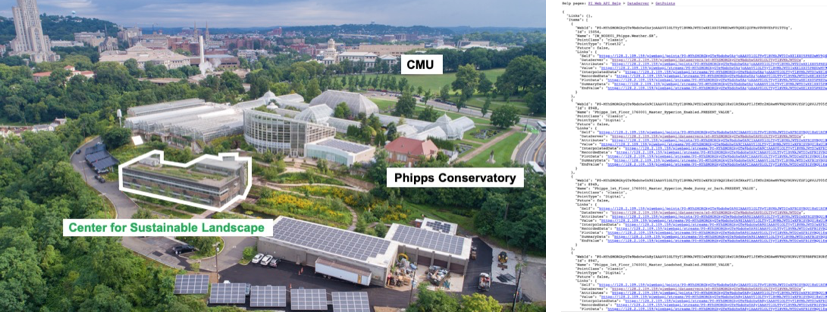

Photo Credit: http://www.sustainablesites.org/phipps-center-sustainable-landscapes


## Pipeline

Data science is a combination of multiple almost-eqaully important tasks. No conclusion can be drawn if any one of the parts is missing from the pipeline. Similar to farm-to-table experience, in this project, we will bring you the database-to-conclusion experience in the following order:

1. **Data collection:** The very first step for a data science project is always getting the data. In our case, we need to query the data from database for all features we need to predict the label. Since the project is done with the collaboration of several students, data will be stored locally as csv files such that other students do not have to query every time they need to use it.

2. **Data processing:** Data processing is a crucial step to ensure machine learning model can perform as we expected. In this step, we will need to clean the data by dropping null values and outliers. The influence of outlier removal will be shown in this report. Then we will conduct feature engineering to either combine some minor features or remove redundant features. The purpose of feature engineering is to reduce the probability of preventing underfitting/overfitting. The processed pandas dataframe will be stored in pickle format such that other teammate can utilize it conveniently.

3. **Machine learning models:** After slightly tedious but extremely beneficial preparing steps, we can then use machine learning models to gain insight into the cleaned dataset, and drawn conclusion from it.

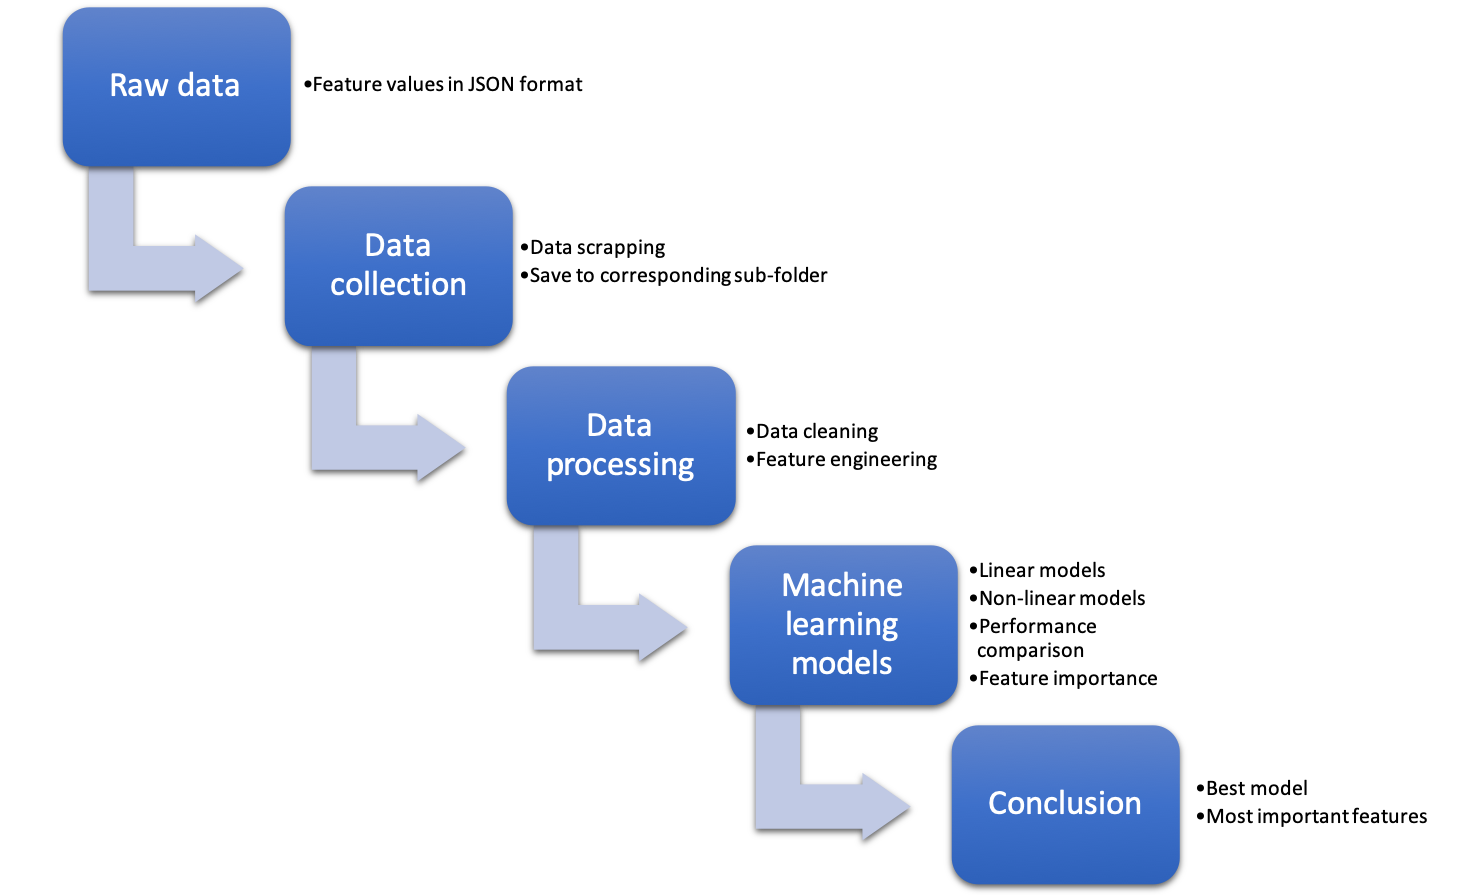

### Import necessary packages

In [1]:
# hide warning, such that deprecated package warning does not show up
import warnings
warnings.filterwarnings('ignore')

# Packages for data collection
import csv, json
import os
import requests
import webbrowser
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager

# Packages for data processing
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for modeling
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.model_selection import train_test_split
import datetime as dt
import scipy.stats as stats

from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data collection

First of all, from a building physics perspective, there are three kinds of factors that are very important to building energy consumption. Besides, we got two energy-related data: interior lighting power and total CSL building power. We manually picked the data listed below and downloaded it through PI Web API. The data stored in dictionaries in the PI database. Each data has its own unique WebID, which can be scrapped through HTTP web query method.

1. Weather Data: Outdoor air temperature; Outdoor air humidity; Outdoor air enthalpy; Outdoor air dew point; Wind direction; Wind speed; Solar radiation
2. Indoor Sensor Data: Indoor air temperature; Indoor air humidity
3. HVAC Unit Data: Supply air temperature; Supply airflow; Mixed air temperature; Geothermal water supply temperature; Geothermal water return temperature

In [3]:
"""
Create folders to store data under different categories
"""
def create_folder():
    new_folders = ["data",
                   "data/weather station",
                   "data/air handling unit",
                   "data/energy",
                   "data/geothermal",
                   "data/zone temperature"]
    for folder in new_folders: 
        try:
            os.makedirs(folder)
        except FileExistsError:
            pass
    return

"""
Create a dictionary mapping data name to corresponding webid
"""
webid_dict = {
                'interior_lighting':'P0-MYhSMORGkyGTe9bdohw0A1yQAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19FTEVDIE1UUiBJTlQuIExJR0hUSU5HX1JFQUxfUE9XRVIuUFJFU0VOVF9WQUxVRQ',
                'total_realPower': "P0-MYhSMORGkyGTe9bdohw0AsyQAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19FTEVDIE1UUiBNRFAtQ1NMX1JFQUxfUE9XRVIuUFJFU0VOVF9WQUxVRQ",
                'outsideair_dewpoint': "P0-MYhSMORGkyGTe9bdohw0AWisAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX0RFV1BPSU5ULlBSRVNFTlRfVkFMVUU",
                'outsideair_enthalpy': "P0-MYhSMORGkyGTe9bdohw0AWSsAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX0VOVEhBTFBZLlBSRVNFTlRfVkFMVUU",
                'outsideair_humidity':'P0-MYhSMORGkyGTe9bdohw0AVTgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMSBPQVQgTU9OSVRPUl9PQSBIVU1JRElUWSBBVi5QUkVTRU5UX1ZBTFVF',
                'outsideair_temp':'P0-MYhSMORGkyGTe9bdohw0AUjgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMSBPQVQgTU9OSVRPUl9PVVRTSURFIEFJUiBURU1QRVJBVFVSRS5QUkVTRU5UX1ZBTFVF',
                'solar_radiation':'P0-MYhSMORGkyGTe9bdohw0AVSsAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX1NPTEFSX1JBRElBVElPTl9BVi5QUkVTRU5UX1ZBTFVF',
                'wind_speed':'P0-MYhSMORGkyGTe9bdohw0AVysAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX1dJTkRfU1BFRURfQVYuUFJFU0VOVF9WQUxVRQ',
                'wind_direction':'P0-MYhSMORGkyGTe9bdohw0AUysAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX1dJTkRfRElSRUNUSU9OX0FWLlBSRVNFTlRfVkFMVUU',
                'geothermal_GTR':'P0-MYhSMORGkyGTe9bdohw0AEjYAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19NRVIgMTEyIEdFT1RIRVJNQUwgTE9PUF9HVFIuUFJFU0VOVF9WQUxVRQ',
                'geothermal_GTS':'P0-MYhSMORGkyGTe9bdohw0AOTgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMV9HVFMuUFJFU0VOVF9WQUxVRQ',
                'AHU-1_mixedair_temp': 'P0-MYhSMORGkyGTe9bdohw0ABDgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMV9NSVhFRCBBSVIgVEVNUC5QUkVTRU5UX1ZBTFVF',
                'AHU-1_supplyair_temp': "P0-MYhSMORGkyGTe9bdohw0ACzgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMV9TVVBQTFkgQUlSIFRFTVAuUFJFU0VOVF9WQUxVRQ",
                'AHU-1_supplyair_flow_kCFM': "P0-MYhSMORGkyGTe9bdohw0AKTgAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19BSFUtMV9TVVBQTFkgQUlSRkxPVyBLQ0ZNLlBSRVNFTlRfVkFMVUU",
                'AHU-1_outdoorair_dewpoint':'P0-MYhSMORGkyGTe9bdohw0AWisAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX0RFV1BPSU5ULlBSRVNFTlRfVkFMVUU',
                'AHU-1_outdoorair_enthalpy':'P0-MYhSMORGkyGTe9bdohw0AWSsAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX0VOVEhBTFBZLlBSRVNFTlRfVkFMVUU',
                'AHU-1_outdoorair_humidity':'P0-MYhSMORGkyGTe9bdohw0AWCsAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX0hVTUlESVRZLlBSRVNFTlRfVkFMVUU',
                'AHU-1_outdoorair_temp':'P0-MYhSMORGkyGTe9bdohw0AVisAAAV0lOLTYyTlBVMkJWTDIwXFBISVBQU19XRUFUSEVSX09BX1RFTVBFUkFUVVJFLlBSRVNFTlRfVkFMVUU'
             }
"""
Create a dictionary mapping data name to corresponding folder
"""
folder_dict = {
                'interior_lighting':"data/energy",
                'total_realPower':"data/energy",
                'outsideair_dewpoint': "data/weather station",
                'outsideair_enthalpy': "data/weather station",
                'outsideair_humidity':"data/weather station",
                'outsideair_temp':"data/weather station",
                'solar_radiation':"data/weather station",
                'wind_speed':"data/weather station",
                'wind_direction':"data/weather station",
                'geothermal_GTR':"data/geothermal",
                'geothermal_GTS':"data/geothermal",
                'AHU-1_mixedair_temp': "data/air handling unit",
                'AHU-1_supplyair_temp': "data/air handling unit",
                'AHU-1_supplyair_flow_kCFM': "data/air handling unit",
                'AHU-1_outdoorair_humidity':"data/air handling unit",
                'AHU-1_outdoorair_temp':"data/air handling unit",
                'AHU-1_outdoorair_dewpoint':"data/air handling unit",
                'AHU-1_outdoorair_enthalpy':"data/air handling unit"
              }
zone_temp_name = [['102',"VAV","temp"],['104',"VAV","temp"],['107E',"VAV","temp"],
                  ['107N',"VAV","temp"],['107NE',"VAV","temp"],['107NW',"VAV","temp"],
                 ['107W',"VAV","temp"],['202',"VAV","temp"],['203',"VAV","temp"],
                 ['204',"VAV-1","temp"],['204',"VAV-2","temp"],['204',"VAV-3","temp"],
                 ['204',"VAV-4","temp"],['204',"VAV-5","temp"],['204',"VAV-6","temp"],
                 ['204',"VAV-7","temp"],['204N',"VAV","temp"],['204NE',"VAV","temp"],
                 ['204NW',"VAV","temp"]]

In [4]:
create_folder()

In [5]:
"""
Methods to get data if webid and data name is known
"""
def getrawFromPi(url):
    content = requests.get(url, auth=('CMU_Students', 'WorkHard!ChangeWorld'), verify=False)
    raw = json.loads(content.text)
    return raw

def queryData(webid, name, starttime, endtime, interval):
    filename = name + '.csv'
    url = 'https://128.2.109.159/piwebapi/streams/' + webid + '/interpolated?starttime=%s&endtime=%s&interval=%s'%(starttime, endtime, interval)
    raw = getrawFromPi(url)
    dataItems = raw['Items']
    formedTimeSeries = []
    for dataItem in dataItems:
        if dataItem['Good']:
            formedTimeSeries.append([dataItem['Timestamp'], dataItem['Value']])
        else:
            formedTimeSeries.append([dataItem['Timestamp'], None])
    with open(filename, 'w') as csv_file:
        wr = csv.writer(csv_file)
        for row in formedTimeSeries:
            wr.writerow(row)
    if "VAV" in filename:
        os.rename(filename, "data/zone temperature/"+filename)
    else:
        os.rename(filename, folder_dict[name]+'/'+filename)

In [6]:
"""
Methods to get data if webid is not known
(For zone temperature data such as 102_VAV_temp)
"""
def getwebidFromPi(wordlist):
    url = 'https://128.2.109.159/piwebapi/dataservers/s0-MYhSMORGkyGTe9bdohw0AV0lOLTYyTlBVMkJWTDIw/points?namefilter=*'
    url += 'phipps*'
    for i in wordlist:
        url += i + '*'
    content = requests.get(url, auth=('CMU_Students', 'WorkHard!ChangeWorld'), verify=False)
    raw = json.loads(content.text)
    webid = raw['Items'][0]['WebId']
    return webid

def download(keywords, starttime, endtime, interval): 
    for name in keywords:
        webid = getwebidFromPi(name)
        name = '_'.join(name)
        queryData(webid, name, starttime, endtime, interval)
    return  None

starttime = '2017-10-01T00:00:00Z'
endtime = '2019-10-01T00:00:00Z'
interval = '10m'

In [7]:
download(zone_temp_name, starttime, endtime, interval)

In [8]:
for name, webid in webid_dict.items():
    queryData(webid, name, starttime, endtime, interval)

## Data processing

Now we have all data (including features and the label) in individual csv files. All csv files have two columns: 1. the specific time that data point is collected and 2. the value. 

The step-to-step walkthrough of data processing section includes:

1. Loading each individual feature and label from the folder contains it into pandas dataframes.
2. Merge all dataframes into a single one that contains all data.
3. Drop all null values and combine some minor features into a large, more general feature.
4. Remove outliers
5. Check correlation between each feature and label. Drop some redundant (strongly correlated to each other) features.
6. Save the processed dataframe into pickle file for teammate to use.

### 4.A Data loading and cleaning

In [9]:
"""
Get names of all csv files in a specific folder
"""
def get_fname(folder):
    f_path = "data/"+folder+"/*.csv"
    fnames = []
    for file in sorted(glob.glob(f_path),key=os.path.getmtime):
        fnames.append(file)
    return fnames

In [10]:
"""
Load csv, set "Date" to be the index, and remove NaN rows
"""
def load_data(path):
    label = path[path.rfind("/")+1 : path.find(".csv")]
    df = pd.read_csv(path,skiprows = [], usecols=[0,1])
    df.columns = ["Date", label]
    df.set_index("Date",inplace = True)
    return df.dropna().sort_index(ascending = True)

In [11]:
folders = ["air handling unit", "weather station", 
           "zone temperature", "geothermal", "energy"]

In [12]:
"""
Read feature data from all folders
"""
dataframes = []
for folder in folders:
    fnames = get_fname(folder)
    for fname in fnames:
        dataframes.append(load_data(fname))

In [13]:
"""
Method to merge dataframes
"""
def merge(df1, df2):
    df1 = df1.dropna().sort_values("Date")
    df2 = df2.dropna().sort_values("Date")
    return pd.merge(df1, df2, on = ["Date"], how = "outer")

In [14]:
"""
Merge all feature data and the label data into a complete dataframe
"""
all_data = dataframes[0]
for df in dataframes[1:]:
    all_data = pd.merge(all_data, df, on = ["Date"], how = "outer")
all_data = all_data.dropna()

In [15]:
"""
Print out the names of each column
"""
print("|"+"Column name:".ljust(27)+"|")
for f in all_data.columns.tolist():
    print("|"+f.rjust(27)+"|")

|Column name:               |
|        AHU-1_mixedair_temp|
|       AHU-1_supplyair_temp|
|  AHU-1_supplyair_flow_kCFM|
|  AHU-1_outdoorair_dewpoint|
|  AHU-1_outdoorair_enthalpy|
|  AHU-1_outdoorair_humidity|
|      AHU-1_outdoorair_temp|
|        outsideair_dewpoint|
|        outsideair_enthalpy|
|        outsideair_humidity|
|            outsideair_temp|
|            solar_radiation|
|                 wind_speed|
|             wind_direction|
|               102_VAV_temp|
|               104_VAV_temp|
|              107E_VAV_temp|
|              107N_VAV_temp|
|             107NE_VAV_temp|
|             107NW_VAV_temp|
|              107W_VAV_temp|
|               202_VAV_temp|
|               203_VAV_temp|
|             204_VAV-1_temp|
|             204_VAV-2_temp|
|             204_VAV-3_temp|
|             204_VAV-4_temp|
|             204_VAV-5_temp|
|             204_VAV-6_temp|
|             204_VAV-7_temp|
|              204N_VAV_temp|
|             204NE_VAV_temp|
|         

### 4.B Feature engineering

From the name of all data, we know that the files in "zone temperature" folder represent the temperature of each zone in the 1st or 2nd floor. To shrink the data set for the purpose of preventing overfitting, we can take mean temperature of zone temperatures in each floor. 

In [16]:
firstfloor_temp = []
secondfloor_temp = []
# Get column names of zone temperature
zone_temps = get_fname("zone temperature")
for zone in zone_temps:
    file = zone[zone.rfind("/")+1 : zone.find(".csv")]
    if file[0] == "1":
        firstfloor_temp.append(file)
    elif file[0] == "2":
        secondfloor_temp.append(file)

In [17]:
all_data["1st_floor_temp"] = all_data[firstfloor_temp].mean(axis = 1)
all_data["2nd_floor_temp"] = all_data[secondfloor_temp].mean(axis = 1)
all_data = all_data.drop(columns = firstfloor_temp + secondfloor_temp)

Air handling unit (AHU) folder and weather station folder both contains data for outdoor air information (temperature, humidity, etc.). Since the air handing unit records the information of air that is closer to the building, we will use the AHU data for building real power consumption prediciton. Weather station data of outdoor air will be used in later study about predicting AHU outdoor air info. 

In [18]:
weather_station_fname = [x[x.rfind("/")+1 : x.find(".csv")] 
                   for x in get_fname("weather station")]

In [19]:
weather_station = all_data[weather_station_fname]

In [20]:
all_data = all_data.drop(columns = [x for x in weather_station_fname
                               if "outsideair" in x])

Finally, rename the total_realPower to Total_power, and move it the end of dataframe as label

In [21]:
all_data["Total_power"] = all_data["total_realPower"]
all_data = all_data.drop(columns = ["total_realPower"])

### 4.C Remove outliers

Firstly, we can plot the distribution of each feature vs. total energy consumption to see if there is any obvious outlier 

In [22]:
def featureVSenergy(data, fname = None):
    Y = data["Total_power"].tolist()
    featureName = data.columns.tolist()
    Xs = [data[x] for x in featureName[:-1]]
    nrow = len(Xs)//5+1
    ncol = 5
    fig, axs = plt.subplots(nrow, ncol, dpi = 150, sharey = True)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    axs = axs.flatten()
    count = 0
    for i, x in enumerate(Xs):
        axs[i].scatter(x, Y, s=1)
        axs[i].set_title(featureName[i], {'fontsize':5})
        axs[i].tick_params(labelsize=6, direction = "in", length = 1.5)
        count +=1 
    # Remove unnecessary empty subplots
    for j in range(count, len(axs)):
        fig.delaxes(axs[j])
    
    # Save figure if fname input is not none (for showing in video)
    if fname != None:
        plt.savefig(fname, dpi=350, bbox_inches = "tight")
    return

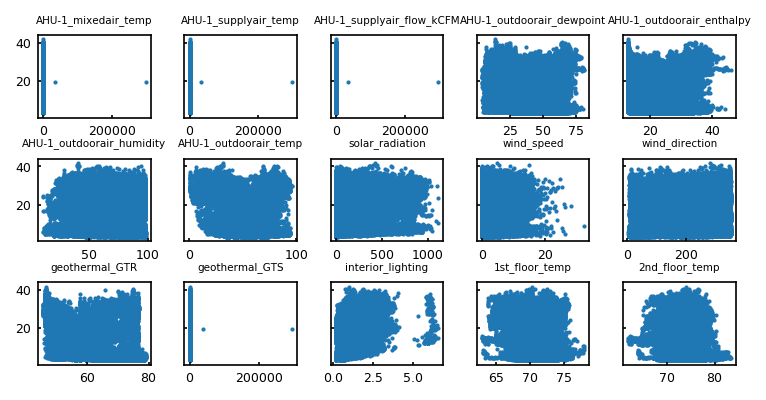

In [23]:
featureVSenergy(all_data)

By plotting out all features versus total energy consumption, we realized two issues. The first one is that there are extreme outliers in some features, such as all AHU-1 air features and geothermal_GTS. The second one is that linear relationship between the features and total energy consumption is not obvious. Therefore linear model might perform well in regression.

Seems like extreme outliers of AHU air data and geothermal_GTS are the same points. Let's drop the top two highest value of AHU-1_supplyair_temp and check again

In [24]:
"""
Here we make a copy of original all_data dataframe, and remove the outliers in the copy.
The reason we do this is that later we can compare the influence of outliers on the linear models
"""
clean_data = all_data.copy()
for i in range(2):
    clean_data = clean_data.drop(clean_data["AHU-1_supplyair_temp"].idxmax())

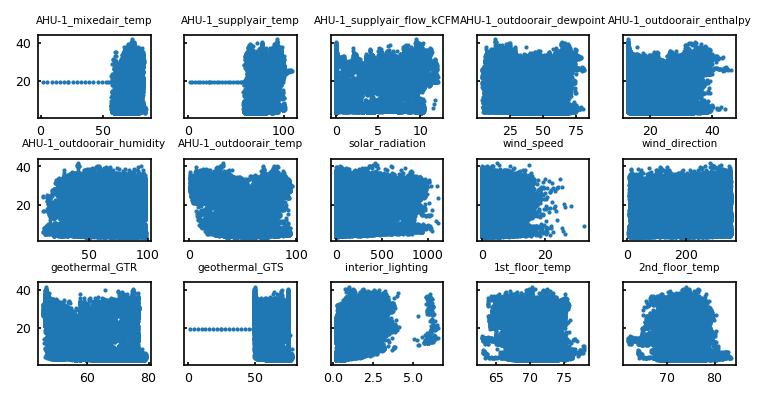

In [25]:
"""
Check if outliers are all removed
"""
featureVSenergy(clean_data)

Sees like there are some other abnormal data points in lower range of AHU-1_supplyair_temp. They should also be removed

In [26]:
for i in range(25):
    clean_data = clean_data.drop(clean_data["AHU-1_supplyair_temp"].idxmin())
for i in range(2):
    clean_data = clean_data.drop(clean_data["AHU-1_outdoorair_enthalpy"].idxmin())

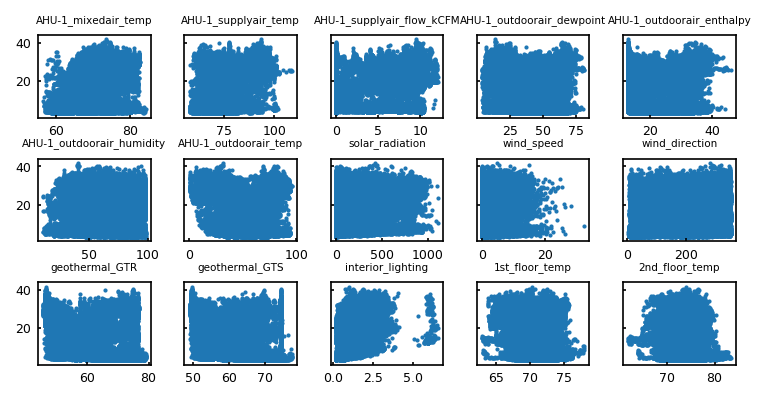

In [27]:
featureVSenergy(clean_data)

The remaining data seems reasonably distributed!

Now we can start to check the correlation features and label.

Ploting a heat map showing the correlation between each feature and label

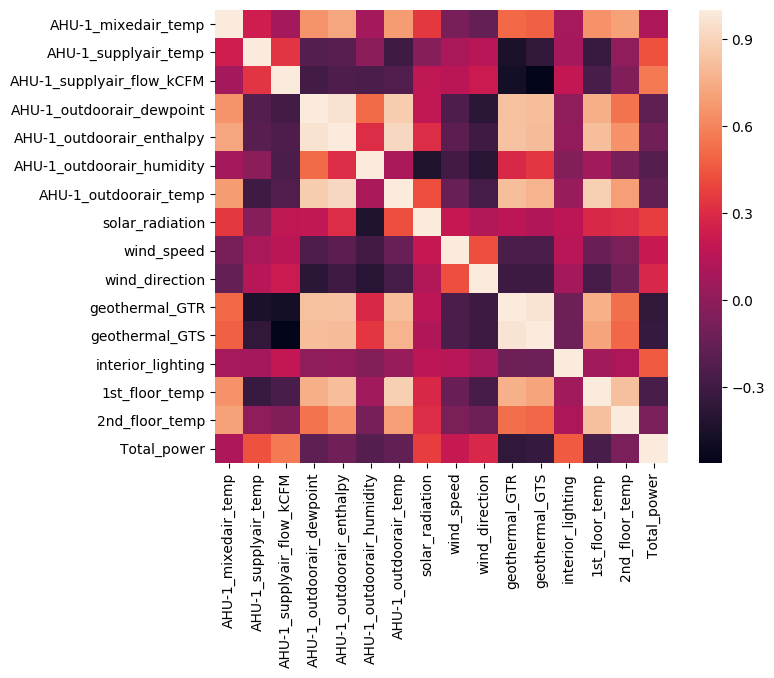

In [28]:
plt.subplots(figsize=(8,6), dpi = 100)
sns.heatmap(clean_data.corr(), vmax=1, square=True)
plt.show()

From the correlation heatmap above, we can see that some of the features are significantly correlated to each other, and they demonstrate similar correlation with the label (e.g. AHU-1_outdoorair_enthalpy with AHU-1_outdoorair_dewpoint and AHU-1_outdoorair_temp; geothermal_GTR and geothermal_GTS). Therefore we can keep only one of them in each similar group to prevent overfitting. 

In [29]:
all_data = all_data.drop(columns = ["AHU-1_outdoorair_enthalpy", 
                                    "AHU-1_outdoorair_dewpoint", 
                                    "geothermal_GTS"])
clean_data = clean_data.drop(columns = ["AHU-1_outdoorair_enthalpy", 
                                        "AHU-1_outdoorair_dewpoint", 
                                        "geothermal_GTS"])

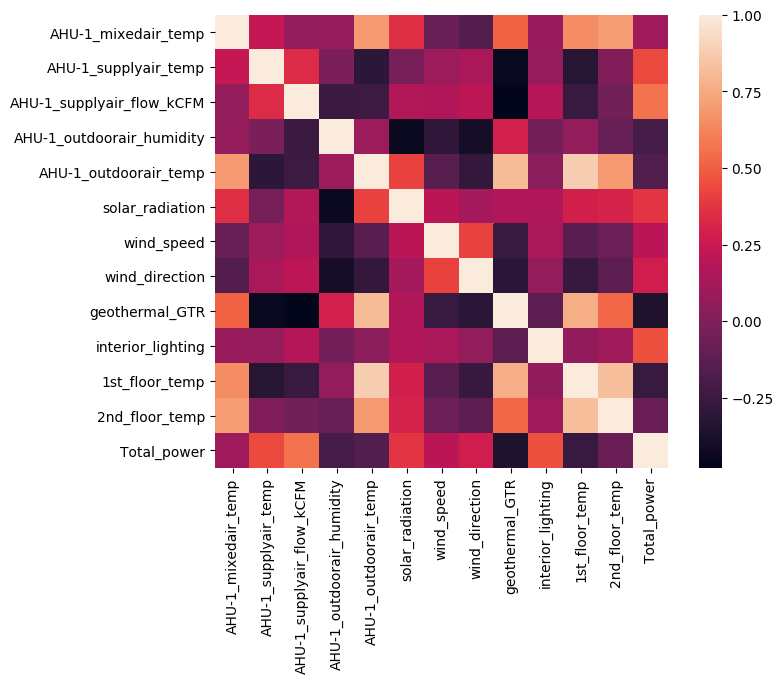

In [30]:
plt.subplots(figsize=(8,6), dpi = 100)
sns.heatmap(clean_data.corr(), vmax=1, square=True)
plt.show()

Final peek into the processed dataset

In [31]:
clean_data.describe()

,AHU-1_mixedair_temp,AHU-1_supplyair_temp,AHU-1_supplyair_flow_kCFM,AHU-1_outdoorair_humidity,AHU-1_outdoorair_temp,solar_radiation,wind_speed,wind_direction,geothermal_GTR,interior_lighting,1st_floor_temp,2nd_floor_temp,Total_power
count,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000,58434.000000
mean,71.367818,76.282404,4.187696,59.348108,54.577727,171.252640,2.367261,188.970434,61.669874,1.230118,70.720393,73.616830,15.861033
std,4.852537,9.300811,4.304458,18.208977,20.046333,247.175843,3.103073,116.561409,9.758485,0.833958,2.406486,2.902951,9.842808
min,56.462105,58.223747,0.000000,10.850000,0.073335,-1.160000,0.000000,5.389000,45.700000,0.159859,62.928571,61.983333,3.144813
25%,68.000000,68.996210,0.000000,45.984166,38.600000,0.310999,0.000000,73.395222,52.809168,0.590846,68.878579,71.484028,5.960911
50%,71.619048,75.150680,2.409989,57.689163,56.446249,15.243996,1.062562,201.657688,61.187001,0.980416,71.195809,74.091667,16.007937
75%,74.721040,80.243332,8.584163,73.333328,71.700000,293.289092,3.708282,301.748657,71.962873,1.770850,72.628571,75.449743,24.484344
max,84.158720,108.625923,12.074475,98.200000,95.765010,1113.147580,32.436825,351.180000,79.000000,6.544492,77.961714,83.326223,41.745876


Looks good!

Save the dataframe for teammates to use

In [32]:
all_data.to_pickle("all_data.pkl")
clean_data.to_pickle("clean_data.pkl")

## Energy consumption prediction

In [33]:
class dataPreprocess(object):
    def __init__(self, topPCAComponents = 0.95, datapath = "clean_data.pkl", testSize = 0.33):
        self.topPCAComponent = topPCAComponents
        self.pcaOrNot = None
        self.datapath = datapath
        self.df = None
        self.testSize = testSize                        #where to split the dataset into train and test set
        
    def loadData(self):
        self.df = pd.read_pickle(self.datapath)
        self.labels = self.df['Total_power']
        self.df = self.df.drop('Total_power', 1)
    
    def getFeatures(self, pcaOrNot = False):
        self.pcaOrNot = pcaOrNot                        #this feature generator would create a version with PCA

        dates = self.df.index.values                    #extract the dats from the index
        self.df['Date'] = pd.to_datetime(dates)         #create a new feature of dates
        
        """
        Convert date into ordianal data just in case we are trying to predict energy consumption using 
        time information
        """
        #as the date is in the string form we need to convert it into the ordinal form
        self.df['Date']=self.df['Date'].map(dt.datetime.toordinal)
        features = self.df.values
        
        X_train, X_test, y_train, y_test = train_test_split(features, self.labels, test_size=self.testSize, random_state=42)
        features = np.delete(features, -1, axis = 1) #remove the time info from the features
        
        #also, we need to seperate the date out from the features as it is not going to be used in the regression
        X_train_ordinal = X_train[:,-1]
        X_test_ordinal = X_test[:,-1]
        trainFeatures =  np.delete(X_train, -1, axis=1)  #we do not need the ordinal time as our train features
        testFeatures = np.delete(X_test, -1, axis= 1)    #same for the test features
        
        #if user wants to use PCA for feature deduction and to prevent overfitting
        if self.pcaOrNot:
            #get data normalized 
            scaler = StandardScaler()
            #normalize the data over the whole dataset
            scaler.fit(features)
            trainFeatures = scaler.transform(trainFeatures)
            testFeatures = scaler.transform(testFeatures)

            #get the PCA
            pca = PCA(self.topPCAComponent)
            pca.fit(trainFeatures)
            trainFeatures, testFeatures = pca.transform(trainFeatures), pca.transform(testFeatures)
            
        return trainFeatures, testFeatures, y_train, y_test, X_train_ordinal, X_test_ordinal
            
    '''If we want to perform the regression on date against variables, 
       we need to convert the date into ordinal form to be a trainable'''
    def fromOrdinal(self,ordinalTime):
        xx = datetime.fromordinal(ordinalTime)
        return {'year': xx.year, 'month':xx.month, 'day' : xx.day}

    def toOrdinal(self, stringDate):
        '''input args: @string, yyyy-mm-dd'''
        d = datetime.strptime(stringDate, '%Y-%m-%d').date()
        return {stringDate : dt.toOrdinal()}
        

In [34]:
"""
Plot method used to plot out:
    1. Distribution of label/predicted label and RSME
    2. KDE of ground truth and predicted label with pearson r
"""
sns.set_style("darkgrid")
%matplotlib inline
def makePlots(options, plots, which, fname = None):
    plt.figure(figsize= (8,6))

    if options == 'distribution':
        legend = []
        for i, data in enumerate(plots):
            #find the rmse between the ground truth and the prediction
            rmse = np.sqrt(mean_squared_error(plots[0], data))
            sns.distplot(data[0:len(data):100])
            legend.append(which[i]+" RMSE:"+str(round(rmse,3)))
        plt.legend(legend, frameon = False, fontsize = 11)
        plt.xlabel("Total Power", fontsize = 15)
        plt.tick_params(labelsize = 15)
        if fname != None:
            plt.savefig("model_comp", dpi=200,bbox_inches = "tight")
        
    elif options == 'kde':
        sns.set(font_scale=1.5)
        for data, w in zip(plots[1::], which[1:]):
            df = np.column_stack((plots[0], data))
            df = pd.DataFrame(df,columns=["Ground Truth", w])
            p = sns.jointplot(x= "Ground Truth", y= w , data= df, kind="kde")
            plt.tick_params(labelsize = 15)
            p.annotate(stats.pearsonr, 
                       frameon = False, fontsize = 15)
            if fname != None:
                plt.savefig(w, dpi=200,bbox_inches = "tight")

            
    plt.show()

In [35]:
processer = dataPreprocess()
processer.loadData()
print("There are in total {} data points and {} features".format(len(processer.df), len(processer.df.columns)))

There are in total 58434 data points and 12 features


In [36]:
"""
Store all feature names in a list
"""
colName = processer.df.columns.tolist()

From the given dataframe, we can see that we have multivariate features with timeseries as the index, the **target** is the "Total_power"

### 5.A Linear model: Ridge regression with/without PCA

Let us first get the features processed without applying PCA

In [37]:
trainFeatures, testFeatures, y_train, y_test, X_train_ordinal, X_test_ordinal = processer.getFeatures()

Let us then operate the PCA onto the train and test data

The reason why we want to do it is because, we are not sure if all the features would be useful to the training process. Thus, we only want to project our data onto a lower dimensional axis where all the projections have a good variance for learning purpose; This is because as we are performing a multivariate regression, the dimension of our model is quite complex, but due to the learning theory which indicates that the training sample is approximately linear to the numbers of features, PCA then can be used to alleviate from overfitting

In [38]:
trainFeatures_pca, testFeatures_pca, _, _,_ ,_ = processer.getFeatures(pcaOrNot=True)

Check the shape of data after PCA

In [39]:
trainFeatures_pca.shape

(39150, 8)

Let us operate the Ridge Regression

By definition, the ridge regression is adding a Norm2 constrains onto the learning parameters. Before adding regularization, the model might try too hard to fit the noise, which would cause a high variance, thus, by introducing the regularization, we acutally allow some of the noise to introduce a little bit bias, but according to the learning theory, this would in turn trade off the overall low variance

But, how do we find the best $\lambda$ ? Let us use the grid search

In [40]:
def findRidge(trainFeatures, testFeatures, y_train, trainFeatures_pca, testFeatures_pca, 
              alphaStart, alphdaEnd, interval):    
    alphas = np.linspace(alphaStart,alphdaEnd,interval)
    ridgeRegression = Ridge()
    clf = GridSearchCV(estimator=ridgeRegression, param_grid=dict(alpha=alphas), n_jobs=-1)
    clf.fit(trainFeatures, y_train)

    clf2 = GridSearchCV(estimator=ridgeRegression, param_grid=dict(alpha=alphas), n_jobs=-1)
    clf2.fit(trainFeatures_pca, y_train)

    #get the best lambda for the ridge regression on the features w/o PCA
    bestLambda1 = clf.best_estimator_.alpha
    #get the best lambda for the ridge regression on the features with PCA
    bestLambda2 = clf2.best_estimator_.alpha
    
    ridgeNonePCA = Ridge(bestLambda1)
    ridgePCA = Ridge(bestLambda2)
    
    ridgeNonePCA.fit(trainFeatures,y_train)
    ridgePCA.fit(trainFeatures_pca,y_train)

    predNonePCA = ridgeNonePCA.predict(testFeatures)
    predPCA = ridgePCA.predict(testFeatures_pca)
    
    return ridgePCA,ridgeNonePCA,predNonePCA,predPCA

In [41]:
"""
Training ridge regression model with/without PCA
"""
ridgePCA,ridgeNonePCA,predNonePCA,predPCA = findRidge(trainFeatures, testFeatures, y_train, trainFeatures_pca, testFeatures_pca,
                                                      0,25,100)

#### Distribution plots of linear models

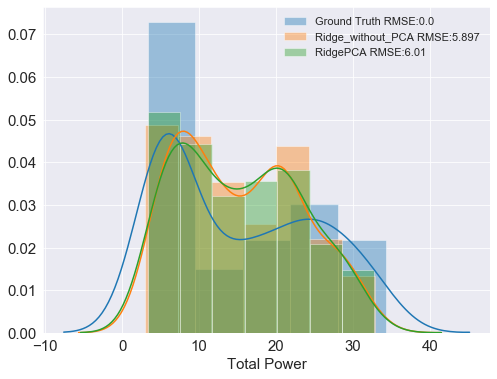

In [42]:
makePlots('distribution', 
          [y_test,predNonePCA, predPCA], 
          ["Ground Truth",'Ridge_without_PCA', 'RidgePCA'])

#### KDE plots of linear models

<Figure size 576x432 with 0 Axes>

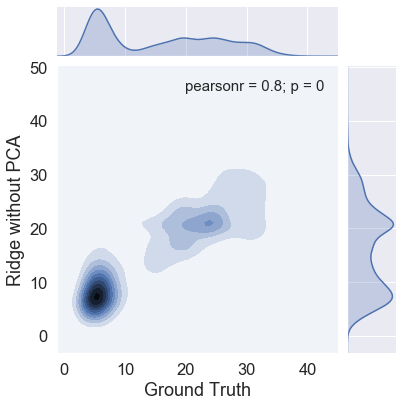

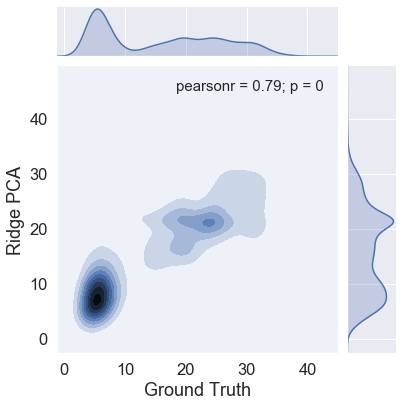

In [43]:
makePlots('kde', 
          [y_test,predNonePCA, predPCA], 
          ["Ground Truth",'Ridge without PCA', 'Ridge PCA'])

### 5.B Non-linear model: Random forest regressor and LightGBM

In [44]:
def RFregressor(trainData, labels, testData):
    RFregr = RandomForestRegressor()
    RFregr.fit(trainData, labels)
    predRF = RFregr.predict(testData)
    return predRF, RFregr

In [45]:
def getLGBModel(trainData, labels, testData, maxIter,verb = True):
    params = {"objective" : "regression", "metric" : "rmse", "num_leaves" : 75, "learning_rate" : 0.01,
    "bagging_fraction" : 0.5, "feature_fraction" : 0.7, "bagging_frequency" : 5, "bagging_seed" : 2018,
    "verbosity" : -1}

    #we need to perform the validation as well
    trainData = pd.DataFrame(trainData, columns=colName)
    
    trainX, valX, trainy, valy = train_test_split(trainData, labels, test_size=0.1, random_state= 1)
    
    trainDataSet = lgb.Dataset(trainX, label=trainy)
    valDataSet = lgb.Dataset(valX, label=valy)
    evaluation = {}
    if verb == True:
        model = lgb.train(params, trainDataSet, maxIter, valid_sets=[valDataSet], 
                          early_stopping_rounds=100, verbose_eval=50, evals_result=evaluation)
    else:
        model = lgb.train(params, trainDataSet, maxIter, valid_sets=[valDataSet], 
                          early_stopping_rounds=100, verbose_eval=False, evals_result=evaluation)
    
    predY = model.predict(testData, num_iteration=model.best_iteration)
    
    return predY, model, evaluation

In [46]:
predRF, modelRF = RFregressor(trainFeatures,y_train,testFeatures)

In [47]:
predLGBM, modelLightGBM, evaluation = getLGBModel(trainFeatures, y_train, testFeatures, 50000)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 6.87137
[100]	valid_0's rmse: 5.14393
[150]	valid_0's rmse: 4.15545
[200]	valid_0's rmse: 3.61237
[250]	valid_0's rmse: 3.30978
[300]	valid_0's rmse: 3.13079
[350]	valid_0's rmse: 3.017
[400]	valid_0's rmse: 2.93824
[450]	valid_0's rmse: 2.87945
[500]	valid_0's rmse: 2.8272
[550]	valid_0's rmse: 2.79031
[600]	valid_0's rmse: 2.75971
[650]	valid_0's rmse: 2.73346
[700]	valid_0's rmse: 2.71223
[750]	valid_0's rmse: 2.69309
[800]	valid_0's rmse: 2.67564
[850]	valid_0's rmse: 2.66113
[900]	valid_0's rmse: 2.64731
[950]	valid_0's rmse: 2.63396
[1000]	valid_0's rmse: 2.62369
[1050]	valid_0's rmse: 2.61314
[1100]	valid_0's rmse: 2.6044
[1150]	valid_0's rmse: 2.59572
[1200]	valid_0's rmse: 2.58567
[1250]	valid_0's rmse: 2.57568
[1300]	valid_0's rmse: 2.56664
[1350]	valid_0's rmse: 2.55659
[1400]	valid_0's rmse: 2.54786
[1450]	valid_0's rmse: 2.54067
[1500]	valid_0's rmse: 2.53458
[1550]	valid_0's rmse: 2.52874
[

#### Distribution plots of Non-linear models

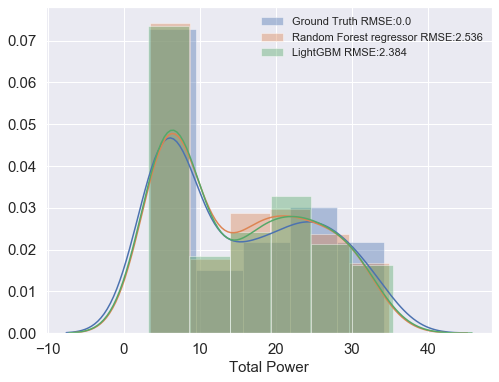

In [48]:
makePlots('distribution', 
          [y_test,predRF, predLGBM], 
          ["Ground Truth",'Random Forest regressor', 'LightGBM'])

#### KDE plots of Non-linear models

<Figure size 576x432 with 0 Axes>

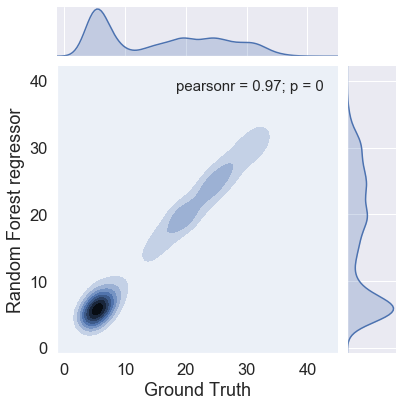

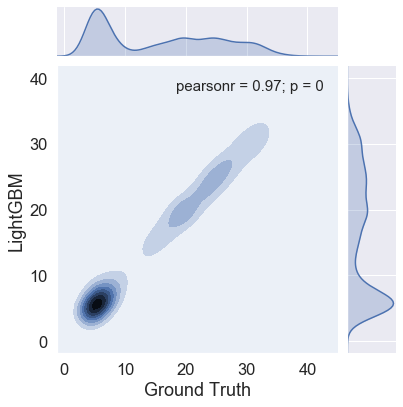

In [49]:
makePlots('kde', 
          [y_test,predRF, predLGBM], 
          ["Ground Truth",'Random Forest regressor', 'LightGBM'])

### 5.C Model comparison & Effect of outliers to linear model performance

From the distribution plots above, we can conclude that:
    
1. Non-linear model generally performs much better in this prediciton problem. Ridge regression (with or without PCA) has RMSE of double the value of Random Forest regressor/LightGBM RMSE. From this KDE plot, we could as well visualize that non-linear models show the most correlated predicted distribution to the ground truth with a high pearson's rate of 0.96 or 0.97(varies between runs).
    
2. Random Forest regressor and LightGBM has performs similarly while LightGBM has slight lead (lower RMSE). Therefore we can conclude that **LightGBM** is the **BEST** model we tested to make prediction for this problem.

At the beginning of this project, our team used the uncleaned data (outlier not removed) for prediction. The accuracy of some of the models suffered from the outliers. We found influence of outliers interesting, thus we will fit the models on uncleaned data and show the comparison as below:

In [50]:
unclean_processer = dataPreprocess(datapath="all_data.pkl")
unclean_processer.loadData()
print("There are in total {} data points and {} features".format(len(unclean_processer.df), 
                                                                 len(unclean_processer.df.columns)))
colName = unclean_processer.df.columns.tolist()
# un stands for unclean
X_train_un, X_test_un, y_train_un, y_test_un, X_train_ordinal_un, X_test_ordinal_un = unclean_processer.getFeatures()
trainFeatures_pca_un, testFeatures_pca_un, _, _,_ ,_ = unclean_processer.getFeatures(pcaOrNot=True)
un_ridgePCA,un_ridgeNonePCA,un_predNonePCA,un_predPCA = findRidge(X_train_un, X_test_un, y_train_un, 
                                                                  trainFeatures_pca_un, testFeatures_pca_un,
                                                                  0,25,100)
predRF_un, modelRF_un = RFregressor(X_train_un,y_train_un,X_test_un)
predLGBM_un, modelLightGBM_un, evaluation_un = getLGBModel(X_train_un, y_train_un, X_test_un, 50000,verb = False)

There are in total 58463 data points and 12 features


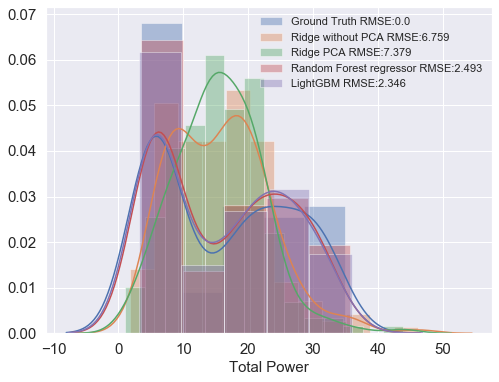

In [51]:
makePlots('distribution', 
          [y_test_un,un_predNonePCA, un_predPCA, predRF_un, predLGBM_un], 
          ["Ground Truth",'Ridge without PCA', 'Ridge PCA', 'Random Forest regressor', 'LightGBM'])

<Figure size 576x432 with 0 Axes>

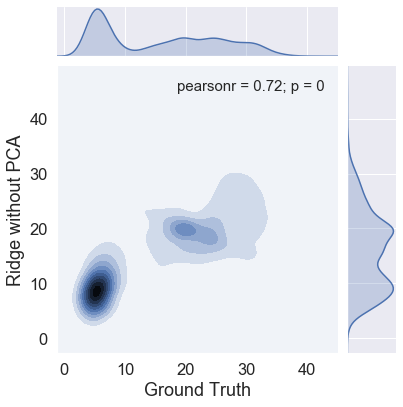

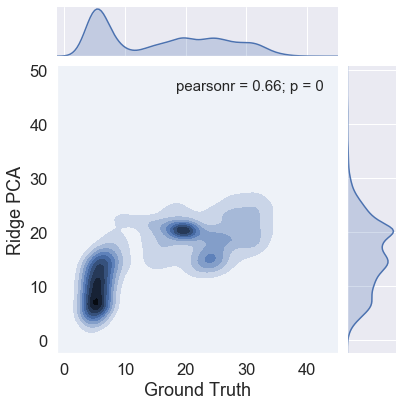

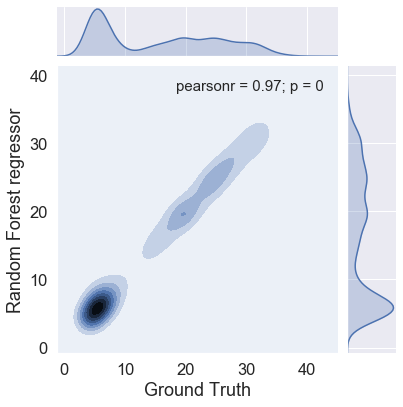

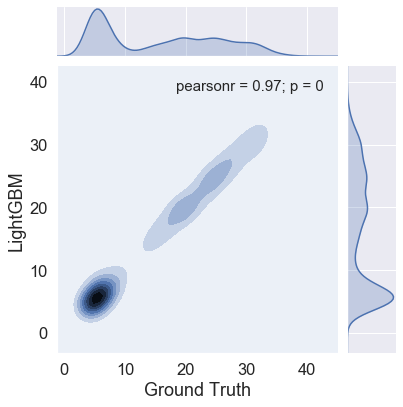

In [52]:
makePlots('kde', 
          [y_test_un,un_predNonePCA, un_predPCA, predRF_un, predLGBM_un], 
          ["Ground Truth",'Ridge without PCA', 'Ridge PCA', 'Random Forest regressor', 'LightGBM'])

We can see that outlier totally ruined the accuracy of ridge regression (Compared to [linear model results using clean data](#KDE-plots-of-linear-models)), while posing no threat to random forest regression or LightGBM (Compared to [non-linear model results using clean data](#KDE-plots-of-Non-linear-models)). Therefore, we can conclude that outlier removal should be a crucial step for linear model regression, and Random Forest/LightGBM is very robust when dealing with outliers.

## Feature importance

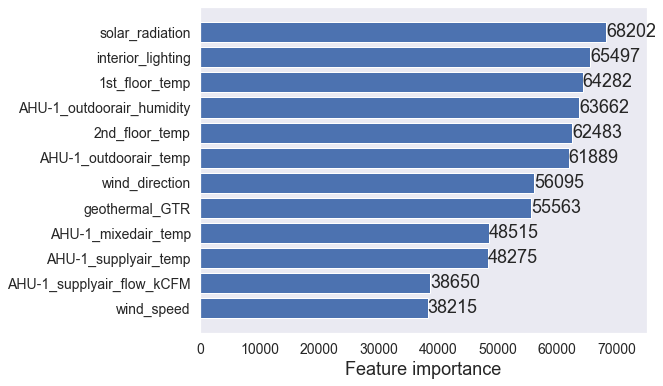

In [53]:
lgb.plot_importance(modelLightGBM, max_num_features=len(colName), height=0.8, 
                    figsize = (8,6), grid = False)
plt.ylabel("", fontsize = 14)
plt.tick_params(labelsize = 14)
plt.title("", fontsize=14)
plt.show()

#### Surprisingly, instead of outdoor temperature, `solar radiation` and `interior lighting` are the two most important features to the building energy consumption.

## Conclusion

According to the result, the solar radiation is the most critical factor for energy consumption instead of outdoor air temperature, which we expected at the beginning. Then, we started to analyze the architectural design information of this building. The CSL building was design by The Design Alliance of Pittsburgh. Architects used a passive-first strategy for building design to achieve energy efficiency. 

#### 1. What is the passive solar design?
The passively solar design is that it utilizes exterior shading, interior ceiling shape, and light shelves to prevent direct sunshine during the summer and contribute heating during the winter. Secondly, the building envelope has a high insulation value and uses phase-change material. Last but not the least, the energy-efficient HVAC systems use ground-source heating and cooling instead of gas or electricity. For a building, most of its energy usage is for taking heating load in winters and cooling load in summers. However, for this CSL building, its heating load significantly depends on outdoor solar radiation due to the passively solar design. 

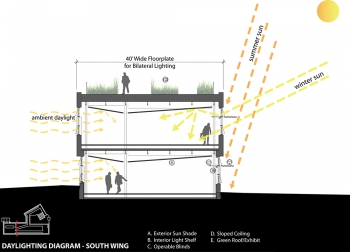

Photo credit: Design Alliance

#### 2. Impact of passive solar design on building energy consumption
Take the comparison between an electric water heater and a solar water heater as the metaphor. The electric one would always consumes the same energy to heat water to the desired water temperature, as long as the original input water temperature is the same. However, the solar water heater utilizes solar radiation to heat the water. If it is cloudy, then water might not be able to achieve the desired temperature and needs to be heated by extra energy. The passively designed CSL building is like the solar water heater.

#### 3. Building energy performance physical insights
1. Passive solar design has a considerable potential for saving building energy consumption, exculding solar radiation for cooling in summers and introducing solar radiation for heating in winters.
2. Most current buildings don't utilize passively solar design and highly rely on fuel-based HVAC systems, which causes the general opinion that outdoor air temperature is an essential feature for energy prediction.
3. Towards a sustainable future, it is critical to consider passive solar design during architecture design phases and utilize the ground-source heat pump as HVAC systems heating and cooling source.


#### 4. Building Energy Prediction: 

Taking account of the excellent energy efficiency characteristic of this CSL building, the result of features importance should be only suitable for energy-efficient buildings or passively solar designed buildings. Besides, for a general building energy prediction, buildings should be categorized by different design strategies and different HVAC systems heating and cooling source.

## Resources and future study

#### Reference
1. Pérez-Lombard, L., Ortiz, J., & Pout, C. (2008). A review on buildings energy consumption information. Energy and buildings, 40(3), 394-398.
1. Zhao, H. X., & Magoulès, F. (2012). A review on the prediction of building energy consumption. Renewable and Sustainable Energy Reviews, 16(6), 3586-3592.